# Imports

In [567]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
#import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Functions

In [568]:
activity_codes = {"jumping": 0, "walking": 1}

# Load and label the data
def load_and_label_data(data_files):
    labeled_data = []
    for person, activities in data_files.items():
        for activity, positions in activities.items():
            for position, file_path in positions.items():
                data = pd.read_csv(file_path)
                data["Activity"] = activity_codes[activity]
                labeled_data.append(data)
    return labeled_data

# Preprocessing and feature extraction functions
def remove_five_seconds_rolling(df, window_size):
    start_time = df["Time (s)"].min()
    end_time = df["Time (s)"].max()
    df = df[(df["Time (s)"] > start_time + 5) & (df["Time (s)"] < end_time - 5)]

    df = df.rolling(window_size).mean()
    df = df.dropna()
    return df

def segment_data(data, window_size=5, sample_rate=100):
    samples = len(data)
    window_samples = window_size * sample_rate
    segments = []
    for i in range(0, samples, window_samples):
        segment = data[i:i+window_samples]
        if len(segment) == window_samples:
            segments.append(segment)
    np.random.shuffle(segments)
    
    return segments

def extract_features(segment):
    features = []
    featured_columns = ['Absolute acceleration (m/s^2)']  # Only keep the absolute acceleration column
    #normalize featured_columns

    for column in featured_columns:  # Exclude the 'Activity' column
        column_data = segment[column]
        #11 features
        mean = column_data.mean()
        std = column_data.std()
        minimum = column_data.min()
        maximum = column_data.max()
        skewness = column_data.skew()
        kurtosis = column_data.kurtosis()
        variance = column_data.var()
        median = column_data.median()
        q1 = column_data.quantile(0.25)
        q3 = column_data.quantile(0.75)
        iqr = q3 - q1
        range = maximum - minimum
        features.extend([mean, std, minimum, maximum, skewness, kurtosis, variance, median, q1, q3, iqr, range])
    return features

def normalize_data(data):
    scaler = MinMaxScaler()
    data.iloc[:, 1:-1] = scaler.fit_transform(data.iloc[:, 1:-1])  # Exclude the 'Activity' column and Time
    return data


# Loading & Pre-processing

In [569]:
#Load the data and preprocess
data_files = {
        "abdellah": {
            "jumping": {
                "backright": "data/jumping/ajbrp_data.csv",
                "frontleft": "data/jumping/ajflp_data.csv",
            },
            "walking": {
                "backright": "data/walking/awbrp_data.csv",
                "frontleft": "data/walking/awflp_data.csv",
            },
    },
  }  # Your data files dictionary with activity and positions

data_files = {
    "kyle": {
        "jumping": {
            "hand": "data/jumping/kjh_data.csv",
            "front": "data/jumping/kjf_data.csv",
            "back": "data/jumping/kjb_data.csv",
            "newback": "data/newData/kyle_jump_back.csv",
            "newfront": "data/newData/kyle_jump_front.csv",
        },
        "walking": {
            "hand": "data/walking/kwh_data.csv",
            "front": "data/walking/kwf_data.csv",
            "back": "data/walking/kwb_data.csv",
            "newback": "data/newData/kyle_walk_back.csv",
            "newfront": "data/newData/kyle_walk_front.csv",
        },
    },
    "abdellah": {
        "jumping": {
            "backright": "data/jumping/ajbrp_data.csv",
            "frontleft": "data/jumping/ajflp_data.csv",
            "hand": "data/NewData/abdellah_jump_hand.csv",
            "pocket": "data/NewData/abdellah_jump_pocket.csv",
        },
        "walking": {
            "backright": "data/walking/awbrp_data.csv",
            "frontleft": "data/walking/awflp_data.csv",
            "pocket": "data/NewData/abdellah_walking_pocket.csv",
        },
    },
    "liam": {
        "jumping": {
            "backleft": "data/jumping/ljlbp_data.csv",
            "backright": "data/jumping/ljbrp_data.csv",
        },
        "walking": {
            "lefthand": "data/walking/lwlh_data.csv",
            "leftpocket": "data/walking/lwlp_data.csv",
            "righthand": "data/walking/lwrh_data.csv",
            "rightpocket": "data/walking/lwrp_data.csv",
        },
    },
}

activity_codes = {"jumping": 0, "walking": 1}

labeled_data = load_and_label_data(data_files)
preprocessed_data = [remove_five_seconds_rolling(df, 5) for df in labeled_data]
normalized_data = [normalize_data(df) for df in preprocessed_data]


# Segmenting and Labelling

In [570]:
# Segmenting and Labelling
segmented_data = []
for data in normalized_data:
    segmented_data.extend(segment_data(data))

# Prepare data and labels
data_matrix = []
label_vector = []

for segment in segmented_data:
    data_matrix.append(extract_features(segment))
    label = segment.iloc[0, -1]
    label_vector.append(label)



# Classification & Dimensionality Reduction

Accuracy: 0.7027027027027027
Recall: 0.7083333333333333


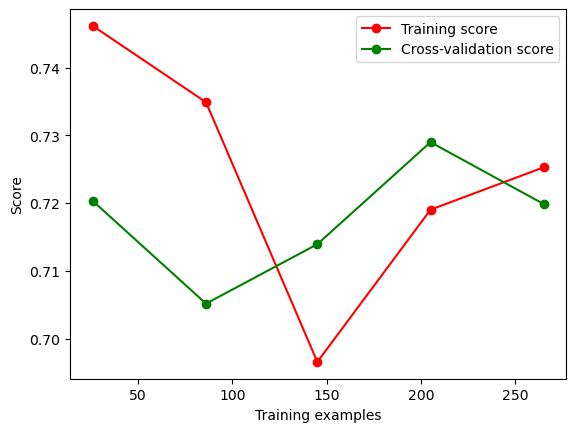

In [571]:
#%%
#Split the data into a training set (90%) and a testing set (10%)
X_train, X_test, Y_train, Y_test = train_test_split(data_matrix, label_vector, test_size=0.1, random_state=42)

#Create a pipeline with PCA and logistic regression
pipe = make_pipeline(PCA(n_components=2), LogisticRegression())

#Train the logistic regression model
pipe.fit(X_train, Y_train)

#Apply the trained model on the test set and record the accuracy
y_pred = pipe.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy}")

recall = recall_score(Y_test, y_pred, average='macro')
print(f"Recall: {recall}")

#Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(pipe, X_train, Y_train, cv=5, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

Accuracy: 0.7027027027027027
Recall: 0.6636904761904762


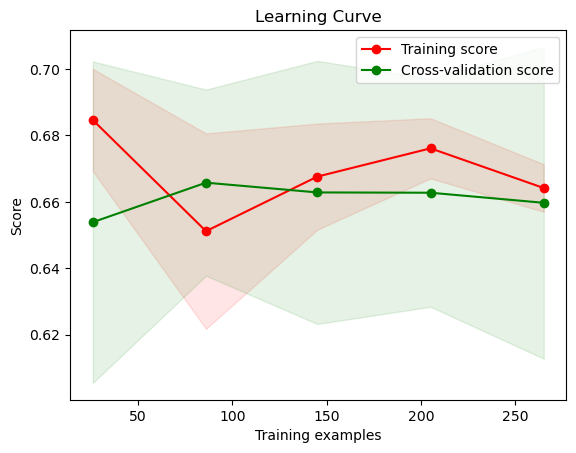

In [572]:
#Split the data into training and testing sets with 90% training and 10% testing
X_train, X_test, Y_train, Y_test = train_test_split(data_matrix, label_vector, test_size=0.1, random_state=42, stratify=label_vector)

#Create a logistic regression model with regularization
log_reg = LogisticRegression(max_iter=10000, penalty='l2')

#Create a pipeline for the PCA and logistic regression
pipeline = make_pipeline(PCA(n_components=0.95), log_reg)

#Train the model
pipeline.fit(X_train, Y_train)

#Apply the trained model on the test set and record the accuracy
y_pred = pipeline.predict(X_test)
acc = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {acc}")

recall = recall_score(Y_test, y_pred, average='macro')
print(f"Recall: {recall}")



#Calculate and plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, Y_train, cv=5, n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve")
plt.show()